# Tech Challenge - Fase 1 (Grupo 40)



**FIAP - Pos Tech - IA para DEVs**

**Professora**: Ana Raquel

**Alunos:**

- Claiton Aparecido Pereira - RM355839
- Eduardo Pedrosa Cajueiro  - RM355819
- Leonardo Lima Ferreira    - RM355721
- Luiz Carvalho             -
- Thiago Cerqueira          -

## Análise e previsão de despesas médicas

O conjunto de dados de seguro médico abrange vários fatores que influenciam as despesas médicas, como idade, sexo, IMC, tabagismo, número de filhos e região. Este conjunto de dados serve de base para o treinamento de modelos de aprendizado de máquina capazes de prever despesas médicas para novos segurados.


# Itens abordados:

* 1 - Análise exploratória dos dados
* 2 - Regressao linear simples
* 3 - Modelo baseado em árvore - DecisionTreeRegressor
* 4 - Modelo baseado em árvore - RandomForestRegressor




# Base de dados

- A base de dados foi obtida do kaggle.com https://www.kaggle.com/datasets/rahulvyasm/medical-insurance-cost-prediction?resource=download :


- **2772** registros
- Não há registros vazios
- **1435** linhas duplicadas
- Após a remoção das linhas duplicas **1337** linhas


# Atributos:

- **age**: idade
- **sex**: Sexo
- **bmi**: indice de massa corporal
- **children**: número de filhos
- **smoker**: fumante
- **region**: região
- **charges**: gasto com o plano de saúde

# Imports necessários para execução

In [26]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy import stats

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold, cross_val_score


from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import StandardScaler


COL_AGE      = 'age'
COL_SEX      = 'sex'
COL_SMOKER   = 'smoker'
COL_REGION   = 'region'
COL_CHILDREN = 'children'
COL_BMI      = 'bmi'
COL_CHARGES  = 'charges' # target

COL_BMI_TYPES= 'bmi-types'  # categorizacao de bmi
COL_AGE_TYPES= 'age-types'  # categorizacao de age


# Functions necessárias para execução

> Adicionar aspas



In [2]:
# carrega a base de dados
def initialize_database():
  dados = pd.read_csv("insurance.csv")
  #dados = pd.read_csv("medical_insurance.csv") # base do kaggle
  print("base de dados inicializada...")
  return dados


# lista os registros duplicados
def list_duplicated(dados):
  duplicados = dados.duplicated()
  numero_duplicados = duplicados.sum()
  print(f"Número de registros duplicados: {numero_duplicados}")

  linhas_duplicadas = dados[duplicados]
  #print(linhas_duplicadas)


# remove os registros duplicados
def remove_duplicated(dados):
  list_duplicated(dados);
  print(dados.shape)
  print("removendo dados duplicados...")
  # Removendo duplicados (por padrão, mantém a primeira linha)
  dados = dados.drop_duplicates()
  # reindexando a base de dados
  dados = dados.reset_index(drop=True)
  print(dados.shape)
  return dados

# Remoção de valores de gastos (charges) discrepantes, de registros que estão acima de 3 desvios padrão da média
def remove_outliers(dados):
  print("removendo outliers...")
  dados = dados[np.abs(stats.zscore(dados[COL_CHARGES])) <3]
  dados = dados.reset_index(drop=True)
  print(dados.shape)
  return dados


# codifica as colunas categóricas em valores númericos para facilitar o uso em modelos de aprendizado de máquina.
def encoded_labels(dados):
  colunas=['sex','smoker','region']
  print("encoded_labels:", colunas )

  label_encoder = LabelEncoder()
  for col in colunas:
    dados[col] = label_encoder.fit_transform(dados[col])
  return dados


# cria uma nova coluna 'bmi-types' de acordo com o intervalos definidos de classificação BMI
def category_bmi(dados):
  print("categorizando a coluna bmi -> bmi-types")
  #dados.loc[:,"bmi-types"] = pd.cut(dados["bmi"],
  dados[COL_BMI_TYPES] = pd.cut(dados[COL_BMI],
                        bins=[0, 18.5, 24.9, 29.9, 34.9, 39.9, np.inf],
                        labels=[1, 2, 3, 4, 5, 6]).cat.codes

  dados = dados.drop(columns = [COL_BMI]).copy()
  #dados.reset_index(drop=True)
  return dados


# cria uma nova coluna 'age-types' de acordo com as faixas etárias da ANS
def category_age(dados):
  print("categorizando a coluna age -> age-types")
  dados[COL_AGE_TYPES] = pd.cut(dados[COL_AGE],
                        bins=[0, 18, 23, 28, 33, 38, 43, 48, 53, 59, np.inf],
                        labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]).cat.codes
  dados = dados.drop(columns = [COL_AGE]).copy()
  return dados


# insere dados na base de dados até n
def run_upsampling(dados):
  print("run_upsampling")
  dados = dados.sample(n=5000, replace=True, random_state=42, ignore_index=True)
  print(dados.shape)
  return dados


def process_database(dados, duplicated, outliers, upsample):
  if duplicated:
    dados = remove_duplicated(dados)
  if outliers:
    dados = remove_outliers(dados)
  if upsample:
     dados = run_upsampling(dados)
  dados = encoded_labels(dados)
  dados = category_bmi(dados)
  #dados = category_age(dados)
  return dados


# definindo as colunas X para predição e Y (target)
def define_x_y():
  y = dados[COL_CHARGES]
  X = dados[[COL_AGE, COL_SEX, COL_SMOKER, COL_REGION, COL_CHILDREN, COL_BMI_TYPES]]
  return X, y

# definindo as colunas X para predição e Y (target)
#def define_x_y_age_types():
#  y = dados[COL_CHARGES]
#  X = dados[[COL_AGE_TYPES, COL_SEX, COL_SMOKER, COL_REGION, COL_CHILDREN, COL_BMI_TYPES]]
#  return X, y


# Esta função divide um conjunto de dados em conjuntos de treino e teste, preservando a distribuição de classes na categoria
def process_train_test(X, y, shuffle=True, standard_scaler=False):
    print("ShuffleSplit bmi-types:", shuffle)
    print("StandardScaler:",standard_scaler)
    if shuffle:
      split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)  # este embaralha os dados antes da divisão
#      for train_index, test_index in split.split(X, X[['age-types', 'bmi-types']]):
      for train_index, test_index in split.split(X, X[COL_BMI_TYPES]):
          shuffe_train = dados.loc[train_index]
          shuffe_test = dados.loc[test_index]

 #     print("% base de treino -------------------")
 #     print(shuffe_train["bmi-types"].value_counts() / len(shuffe_train))

 #     print("% base de teste ---------------------")
 #     print(shuffe_test["bmi-types"].value_counts() / len(shuffe_test))

      if COL_BMI_TYPES != COL_BMI:
        print("removendo coluna bmi-types")
        for set_ in (shuffe_train, shuffe_test):
          set_.drop(COL_BMI_TYPES, axis=1, inplace=True)


      X_train = shuffe_train.copy()
      y_train = X_train[COL_CHARGES].copy()

      X_train = X_train.drop(columns=[COL_CHARGES], axis=1)

      X_test = shuffe_test.copy()
      y_test = X_test[COL_CHARGES].copy()

      X_test = X_test.drop(columns=[COL_CHARGES], axis=1)
    else:
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if standard_scaler:
      scaler = StandardScaler() #chamando o metodo de padronização dos dados (média e std)
      X_train = scaler.fit_transform(X_train)
      X_test = scaler.transform(X_test)

    return X_train, y_train, X_test, y_test


def calculate_mape(labels, predictions):
    errors = np.abs(labels - predictions)
    relative_errors = errors / np.abs(labels)
    mape = np.mean(relative_errors) * 100
    return mape


# Esta função avalia o desempenho de um modelo de regressão e retorna um dicionário com métricas de desempenho.
def model_evaluate(model, X_train, y_train, X_test, y_test, y_pred):
  #print("Avaliando o desempenho do modelo: ", model.__class__.__name__)
  mse = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  mape = calculate_mape(y_test, y_pred)
  rmse = np.sqrt(mse);

#  print("mse - Mean Squared Error :", mse)
#  print("mae - Mean Absolute Error:", mae)
  print(f"Avaliando o desempenho do modelo: {model.__class__.__name__} - r2-score: {r2}")

#  print("O score nos dá uma visão da precisão média da floresta aleatória nos dados")
#  print("score train: ", model.score(X_train, y_train))
#  print("score test : ", model.score(X_test, y_test))

  score_std, score_mean = validacao_cruzada(model)

  return {'model': model.__class__.__name__,
                    'shuffle_split_bmi': shuffle_split,
                    'upsampling': upsampling,
                    'standard_scaler': standard_scaler,
                    'removed_outliers': removed_outliers,
                    'mae': mae.round(2),
                    'mse': mse.round(2),
                    'rmse': rmse.round(2),
                    'mape': mape.round(2),
                    'r2-score': r2.round(4),
                    'k-fold std': score_std,
                    'k-fold mean': score_mean  }



# realiza validação cruzada k-fold para avaliar o desempenho de um modelo de regressão e retorna o desvio padrão e a média dos scores de R².
def validacao_cruzada(model, k=10):
  #print("Validação cruzada:", k, model.__class__.__name__,)

  # Realize a validação cruzada e armazene os resultados em 'scores'
  scores = cross_val_score(model, X, y, cv=KFold(n_splits=k, shuffle=True, random_state=42))

#  print("K-Fold (R^2) Scores: {0}".format(scores))
#  print("Desvio padrão do R²:", scores.std())
  #print("Média do R²:", scores.mean())
  return scores.std(), scores.mean()


def plt_real_previsto(y_test, predictions, model):
  plt.scatter(y_test, predictions)
  plt.xlabel('Encargo Real')
  plt.ylabel('Encargo Previsto')
  plt.title('Real vs Previsto - ' + model.__class__.__name__)
  ideal_values = np.linspace(min(y_test), max(y_test))
  plt.plot(ideal_values, ideal_values, color='red', label='Ideal')
  plt.legend()
  plt.show()


# cria, treina e utiliza um modelo de regressão linear para prever valores em um conjunto de dados de teste.
def linear_regression():
  model = LinearRegression()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  return model, y_pred


# cria, treina e utiliza um modelo de Regressão por Árvore de Decisão para prever valores em um conjunto de dados de teste.
def decision_tree_regressor():
  model = DecisionTreeRegressor(random_state=42)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  return model, y_pred


#  cria, treina e utiliza um modelo de Regressão Random Forest para prever valores em um conjunto de dados de teste.
def radom_forest_regressor():
  model = RandomForestRegressor(n_estimators=100, random_state=42)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  return model, y_pred


def add_rating(evaluation, ratings):
  df = pd.DataFrame([evaluation])
  ratings = pd.concat([ratings, df], ignore_index=True)
  return ratings


def model_run(engine, ratings):
  if (engine == "decision_tree_regressor"):
    model, y_pred = decision_tree_regressor()
  elif (engine == "radom_forest_regressor"):
    model, y_pred = radom_forest_regressor()
  elif (engine == "linear_regression"):
    model, y_pred = linear_regression()

  evaluate = model_evaluate(model, X_train, y_train, X_test, y_test, y_pred)

  ratings = add_rating(evaluate, ratings)

  return ratings



#  Inicializando a base de dados

In [59]:
# dados = pd.read_csv("insurance2.csv")
dados = pd.read_csv("medical_insurance.csv")


# 1 - Exploração inicial dos dados

In [ ]:
dados.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
dados.shape

(2772, 7)

In [ ]:
dados

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
2767,47,female,45.320,1,no,southeast,8569.86180
2768,21,female,34.600,0,no,southwest,2020.17700
2769,19,male,26.030,1,yes,northwest,16450.89470
2770,23,male,18.715,0,no,northwest,21595.38229


In [ ]:
dados.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [ ]:
dados.describe().T

,count,mean,std,min,25%,50%,75%,max
age,2772.0,39.109668,14.081459,18.0000,26.000,39.00000,51.0000,64.00000
bmi,2772.0,30.701349,6.129449,15.9600,26.220,30.44750,34.7700,53.13000
children,2772.0,1.101732,1.214806,0.0000,0.000,1.00000,2.0000,5.00000
charges,2772.0,13261.369959,12151.768945,1121.8739,4687.797,9333.01435,16577.7795,63770.42801


In [46]:
dados.groupby(COL_SEX).describe()

age                                                     children  \
      count       mean        std   min   25%   50%   75%   max    count   
sex                                                                        
0    2421.0  39.762495  14.011424  18.0  27.0  40.0  52.0  64.0   2421.0   
1    2579.0  38.843738  14.084446  18.0  26.0  39.0  51.0  64.0   2579.0   

               ...      charges              bmi-types                      \
         mean  ...          75%          max     count      mean       std   
sex            ...                                                           
0    1.071458  ...  15019.76005  63770.42801    2421.0  2.570012  1.178208   
1    1.120589  ...  18310.74200  62592.87309    2579.0  2.724699  1.178179   

                              
     min  25%  50%  75%  max  
sex                           
0    0.0  2.0  3.0  3.0  5.0  
1    0.0  2.0  3.0  4.0  5.0  

[2 rows x 48 columns]

In [ ]:
dados.groupby(COL_SMOKER).describe()

age                                                          bmi  \
         count       mean        std   min    25%   50%   75%   max   count   
smoker                                                                        
no      1064.0  39.385338  14.083410  18.0  26.75  40.0  52.0  64.0  1064.0   
yes      274.0  38.514599  13.923186  18.0  27.00  38.0  49.0  64.0   274.0   

                   ... children      charges                              \
             mean  ...      75%  max   count          mean           std   
smoker             ...                                                     
no      30.651795  ...      2.0  5.0  1064.0   8434.268298   5993.781819   
yes     30.708449  ...      2.0  5.0   274.0  32050.231832  11541.547176   

                                                                          
               min           25%          50%           75%          max  
smoker                                                                    
no       1121.8739   3986.438700   7345.40530  11362.887050  36910.60803  
yes     12829.4551  20826.244213  34456.34845  41019.207275  63770.42801  

[2 rows x 32 columns]

In [47]:
dados.groupby(COL_REGION).describe()

age                                                         sex  \
         count       mean        std   min   25%   50%   75%   max   count   
region                                                                       
0       1231.0  39.606824  13.886582  18.0  27.0  40.0  51.0  64.0  1231.0   
1       1208.0  39.854305  14.123035  19.0  26.0  40.0  53.0  64.0  1208.0   
2       1330.0  38.400000  14.189177  18.0  26.0  38.0  51.0  64.0  1330.0   
3       1231.0  39.375305  13.982295  19.0  26.5  39.0  51.0  64.0  1231.0   

                  ...      charges              bmi-types                      \
            mean  ...          75%          max     count      mean       std   
region            ...                                                           
0       0.504468  ...  18648.42170  58571.07448    1231.0  2.396426  1.175130   
1       0.518212  ...  14254.60820  60021.39897    1208.0  2.373344  1.046009   
2       0.515038  ...  20781.48892  63770.42801    1330.0  3.126316  1.209686   
3       0.525589  ...  13224.69300  52590.82939    1231.0  2.659626  1.115443   

                                 
        min  25%  50%  75%  max  
region                           
0       0.0  2.0  2.0  3.0  5.0  
1       0.0  2.0  2.0  3.0  5.0  
2       1.0  2.0  3.0  4.0  5.0  
3       0.0  2.0  3.0  3.0  5.0  

[4 rows x 48 columns]

In [48]:
dados.groupby(COL_CHILDREN).describe()

age                                                          sex  \
           count       mean        std   min    25%   50%   75%   max   count   
children                                                                        
0         2135.0  38.663232  16.415939  18.0  22.00  36.0  56.0  64.0  2135.0   
1         1224.0  39.790033  12.198114  18.0  30.00  40.0  49.0  64.0  1224.0   
2          898.0  39.543430  11.714307  18.0  30.25  40.0  48.0  64.0   898.0   
3          569.0  40.666081  12.183208  18.0  30.00  40.0  51.0  64.0   569.0   
4          113.0  39.725664  11.098784  18.0  32.00  40.0  48.0  61.0   113.0   
5           61.0  33.704918   9.218359  19.0  25.00  33.0  39.0  52.0    61.0   

                    ...       charges              bmi-types            \
              mean  ...           75%          max     count      mean   
children            ...                                                  
0         0.505855  ...  13981.850350  63770.42801    2135.0  2.627635   
1         0.526961  ...  16450.894700  58571.07448    1224.0  2.674020   
2         0.517817  ...  20782.487982  49577.66240     898.0  2.690423   
3         0.497364  ...  20462.997660  60021.39897     569.0  2.662566   
4         0.566372  ...  17128.426080  40182.24600     113.0  2.548673   
5         0.688525  ...   8965.795750  14478.33015      61.0  2.409836   

                                             
               std  min  25%  50%  75%  max  
children                                     
0         1.205457  0.0  2.0  3.0  3.0  5.0  
1         1.145553  0.0  2.0  3.0  3.0  5.0  
2         1.253729  0.0  2.0  3.0  4.0  5.0  
3         1.080568  1.0  2.0  3.0  3.0  5.0  
4         0.886316  1.0  2.0  2.0  3.0  5.0  
5         1.243343  1.0  1.0  2.0  3.0  5.0  

[6 rows x 48 columns]

<Axes: xlabel='sex', ylabel='Count'>

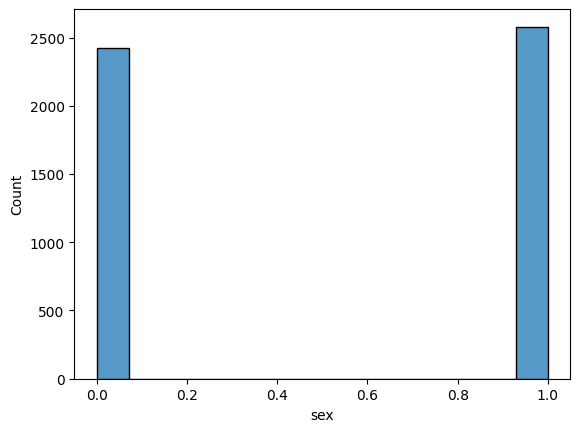

In [49]:
sb.histplot(data=dados, x=COL_SEX)

<Axes: xlabel='children', ylabel='Count'>

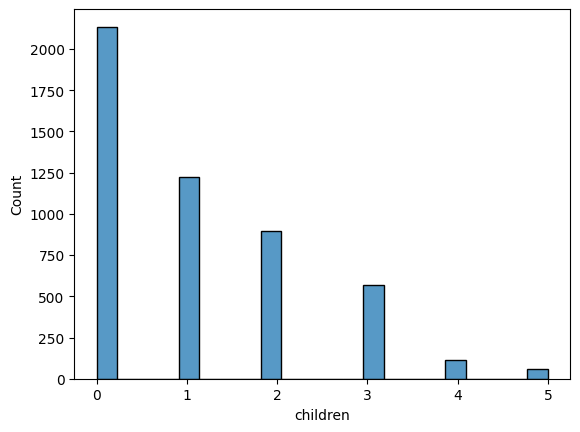

In [50]:
sb.histplot(data=dados, x=COL_CHILDREN)

<Axes: xlabel='bmi', ylabel='Count'>

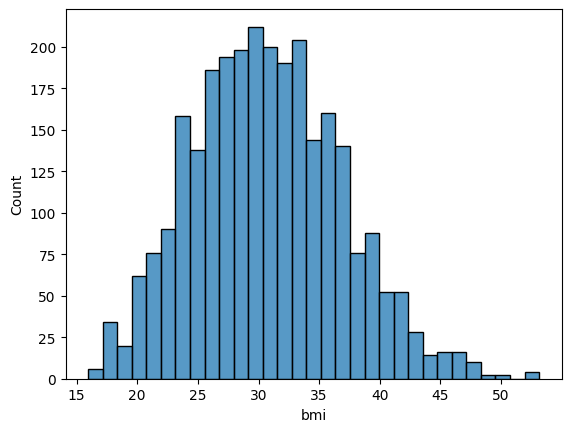

In [61]:
sb.histplot(data=dados, x=COL_BMI)

<Axes: ylabel='charges'>

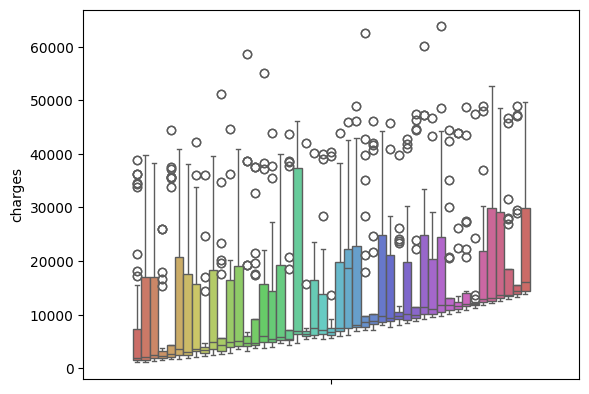

In [62]:
sb.boxplot(hue=COL_AGE, y=COL_CHARGES, data=dados, palette='hls', legend=False)

**Obs:** Pode ser observado nesse gráfico, a relação da idade e dos gastos, que com o avanço da idade os gastos vão aumentando....

<Axes: xlabel='smoker', ylabel='charges'>

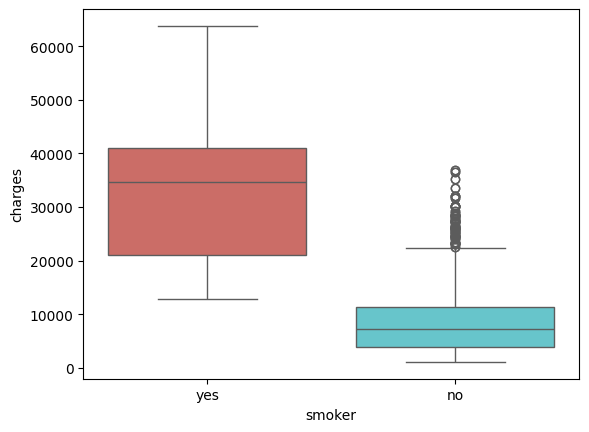

In [63]:
sb.boxplot(x=COL_SMOKER, y=COL_CHARGES, hue=COL_SMOKER, data=dados, palette='hls', legend=False)

**Obs:** Nesse gráfico pode ser observado que o fumante tem um gasto maior, em relação ao não fumante.

<Axes: xlabel='sex', ylabel='charges'>

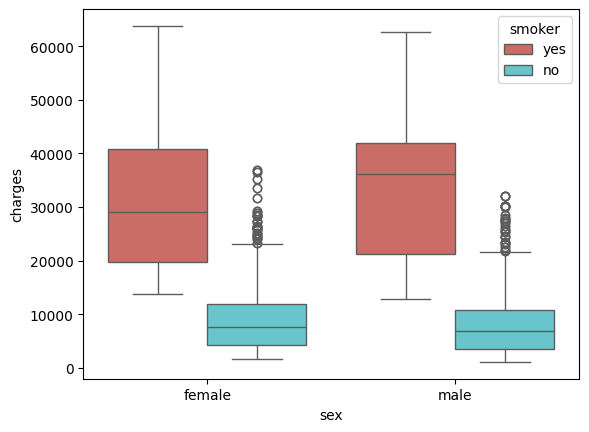

In [64]:

sb.boxplot(x=COL_SEX, y=COL_CHARGES, hue=COL_SMOKER, data=dados, palette='hls', legend=True)

<Axes: xlabel='charges'>

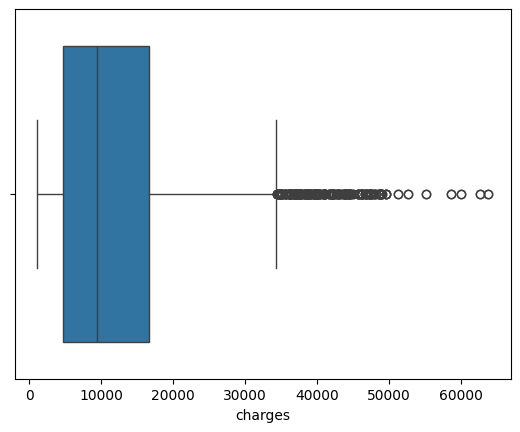

In [65]:
sb.boxplot(x=dados[COL_CHARGES])

<Axes: xlabel='bmi'>

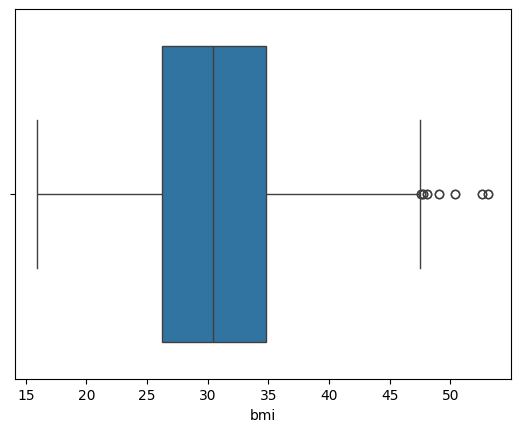

In [66]:
sb.boxplot(x=dados[COL_BMI])

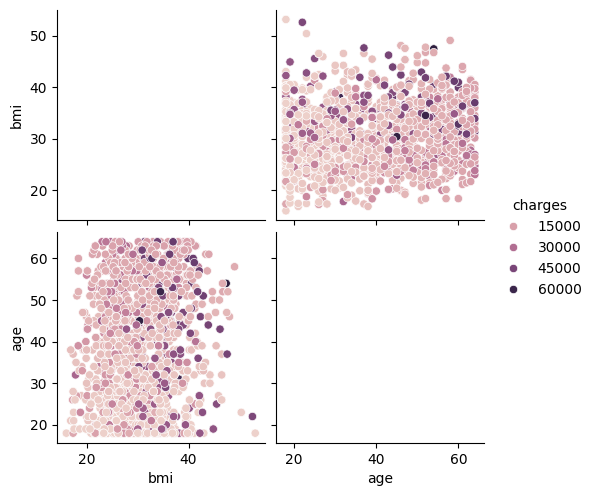

In [67]:
sb.pairplot(dados,vars=[COL_BMI, COL_AGE],hue=COL_CHARGES)

**Obs:** Nesses gráficos, pode ser observar que quanto maior o bmi (indice de massa corportal) maior o gasto com o plano de saúde, o mesmo com  avanço da idade.

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 75.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 58.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 62.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 83.3% of the points cannot be plac

[Text(13.000000000000002, 0.5, '')]

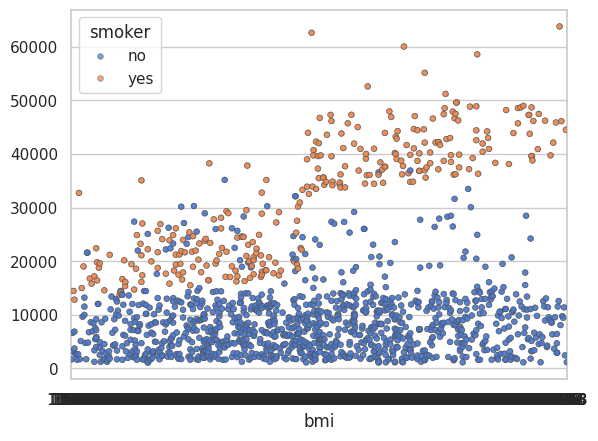

In [68]:
sb.set_theme(style="whitegrid", palette="muted")
ax = sb.swarmplot(data=dados, x=COL_BMI, y=COL_CHARGES, hue=COL_SMOKER, size=4, linewidth=0.5,  alpha=0.7)
ax.set(ylabel="")

**Obs:** Aqui neste gráfico (smoker, bmi e charges), pode perceber que fumantes tem mais gastos com o plano de saude e quanto mais alto IMC o gasto vai aumentando


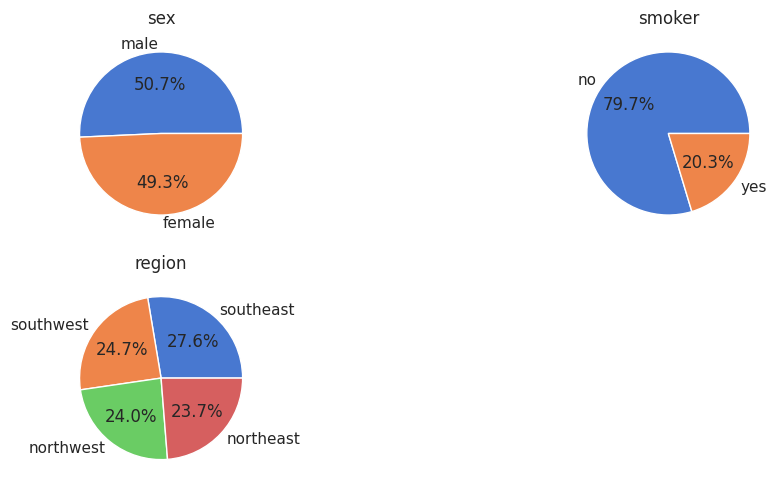

In [69]:
plt.figure(figsize=(12,9))
for i,col in enumerate([COL_SEX, COL_SMOKER, COL_REGION]):
    plt.subplot(3,2,i+1)
    x=dados[col].value_counts().reset_index()
    plt.title(col)
    plt.pie(x=x['count'],labels=x[col],autopct="%0.1f%%",colors=sns.color_palette('muted'))

#2 - Processando os dados

Foram utilizadas as seguintes funcionalidades:

- Eliminação  de registros duplicados;
- label enconder;
- categorizando BMI;
- Upsampling
- StandardScaler

**2.1 - Eliminação de Registros duplicados**


* Listando os registros duplicados da base de dados




In [ ]:
list_duplicated(dados)

Número de registros duplicados: 3704


- removendo os registros duplicados

In [ ]:

dados = remove_duplicated(dados)


Número de registros duplicados: 1435
(2772, 7)
removendo dados duplicados...
(1337, 7)


**2.2 - Removendo outliers**

Remoção de valores de gastos (charges) discrepantes, de registros que estão acima de 3 desvios padrão da média

In [ ]:
dados = remove_outliers(dados)

removendo outliers...
(1330, 7)
(1321, 7)


remoção de valores discrepantes com base nas pontuações **z** em um conjunto de dados​. Quando aplicamos a regra dos **3 desvios padrão**, estamos considerando que mais de **99%** dos dados estão dentro deste intervalo em uma distribuição normal.
Assim, os valores que estão além de 3 desvios padrão da média são considerados incomuns ou **outliers**.

**OBS:** é removido 7 registros, considerados outliers

**2.3 - LabelEncoder**

Vamos utilizar **label enconder** para tratar variáveis categóricas: **sex, smoker e region**

In [ ]:
dados = encoded_labels(dados)

dados.head()

encoded_labels: ['sex', 'smoker', 'region']


,sex,children,smoker,region,charges,bmi-types,age-types
0,0,0,1,3,16884.92400,2,1
1,1,1,0,2,1725.55230,3,0
2,1,3,0,2,4449.46200,3,2
3,1,0,0,1,21984.47061,1,3
4,1,0,0,1,3866.85520,2,3


**2.4 - Categorizando BMI**

**`O índice de massa corporal ( IMC )`** é um valor derivado da massa ( peso ) e altura de uma pessoa. O IMC é definido como a massa corporal dividida pelo quadrado da altura corporal e é expresso em unidades de kg/m 2




IMC, categorias básicas Categoria	IMC (kg/m 2 )
- Abaixo do peso (magreza severa):	< 16,0
- Abaixo do peso (magreza moderada):	16,0 – 16,9
- Abaixo do peso (magreza leve):	17,0 – 18,4
- Intervalo normal:	18,5 – 24,9
- Excesso de peso (pré-obeso):	25,0 – 29,9
- Obeso (Classe I):	30,0 – 34,9
- Obeso (Classe II):	35,0 – 39,9
- Obeso (Classe III):	≥ 40,0

In [ ]:
dados = category_bmi(dados)
dados[COL_BMI_TYPES]

categorizando a coluna bmi -> bmi-types


0       2
1       3
2       3
3       1
4       2
       ..
1325    3
1326    3
1327    4
1328    2
1329    2
Name: bmi-types, Length: 1330, dtype: int8

**2.5 - Categorizando Age**

**Categorizando idades por faixas etárias**

Faixas definidas pela  ANS - Agência Nacional de Saúde Suplementar:

- 0 a 18 anos
- 19 a 23 anos
- 24 a 28 anos
- 29 a 33 anos
- 34 a 38 anos
- 39 a 43 anos
- 44 a 48 anos
- 49 a 53 anos
- 54 a 58 anos
- 59 anos ou mais

In [ ]:
dados = category_age(dados)
dados[COL_AGE_TYPES]

categorizando a coluna age -> age-types


0       1
1       0
2       2
3       3
4       3
       ..
2767    6
2768    1
2769    1
2770    1
2771    8
Name: age-types, Length: 2772, dtype: int8

**2.6 - Upsampling**

**Upsampling** é uma técnica de manipulação de dados usada para resolver o desequilíbrio de classes em conjuntos de dados, mas é importante considerar suas limitações, como **Overfitting**

In [ ]:
dados = run_upsampling(dados)

upsampling = True
dados.shape


(5000, 7)

**2.7 - StandardScaler**

**Obs:** Não há melhoras no modelo, usando StandardScaler

In [70]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() #chamando o metodo de padronização dos dados (média e std)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

y_pred = rf.predict(X_test_scaled)

model_evaluate(rf, X_train_scaled, y_train, X_test_scaled, y_test, y_pred)

Avaliando o desempenho do modelo: RandomForestRegressor - r2-score: 0.9133108562375221


{'model': 'RandomForestRegressor',
 'shuffle_split_bmi': True,
 'upsampling': True,
 'standard_scaler': False,
 'removed_outliers': False,
 'mae': 1407.45,
 'mse': 12499630.29,
 'rmse': 3535.48,
 'mape': 12.72,
 'r2-score': 0.9133,
 'k-fold std': 0.0066202143890745175,
 'k-fold mean': 0.9790705388390386}

# 3 - Exploração de dados após ajustes

In [ ]:
dados.head()


,sex,children,smoker,region,charges,bmi-types,age-types
0,0,0,1,3,16884.92400,2,1
1,1,1,0,2,1725.55230,3,0
2,1,3,0,2,4449.46200,3,2
3,1,0,0,1,21984.47061,1,3
4,1,0,0,1,3866.85520,2,3


In [11]:
dados.describe().T

,count,mean,std,min,25%,50%,75%,max
age,5000.0,39.307200,14.138473,18.0000,26.0000,40.0000,51.00000,64.0000
sex,5000.0,0.498800,0.500049,0.0000,0.0000,0.0000,1.00000,1.0000
children,5000.0,1.087000,1.203046,0.0000,0.0000,1.0000,2.00000,5.0000
smoker,5000.0,0.199000,0.399288,0.0000,0.0000,0.0000,0.00000,1.0000
region,5000.0,1.525400,1.090134,0.0000,1.0000,2.0000,2.00000,3.0000
charges,5000.0,12989.817179,11561.228404,1121.8739,4753.6368,9432.9253,16420.49455,49577.6624
bmi-types,5000.0,2.666000,1.191943,0.0000,2.0000,3.0000,3.00000,5.0000


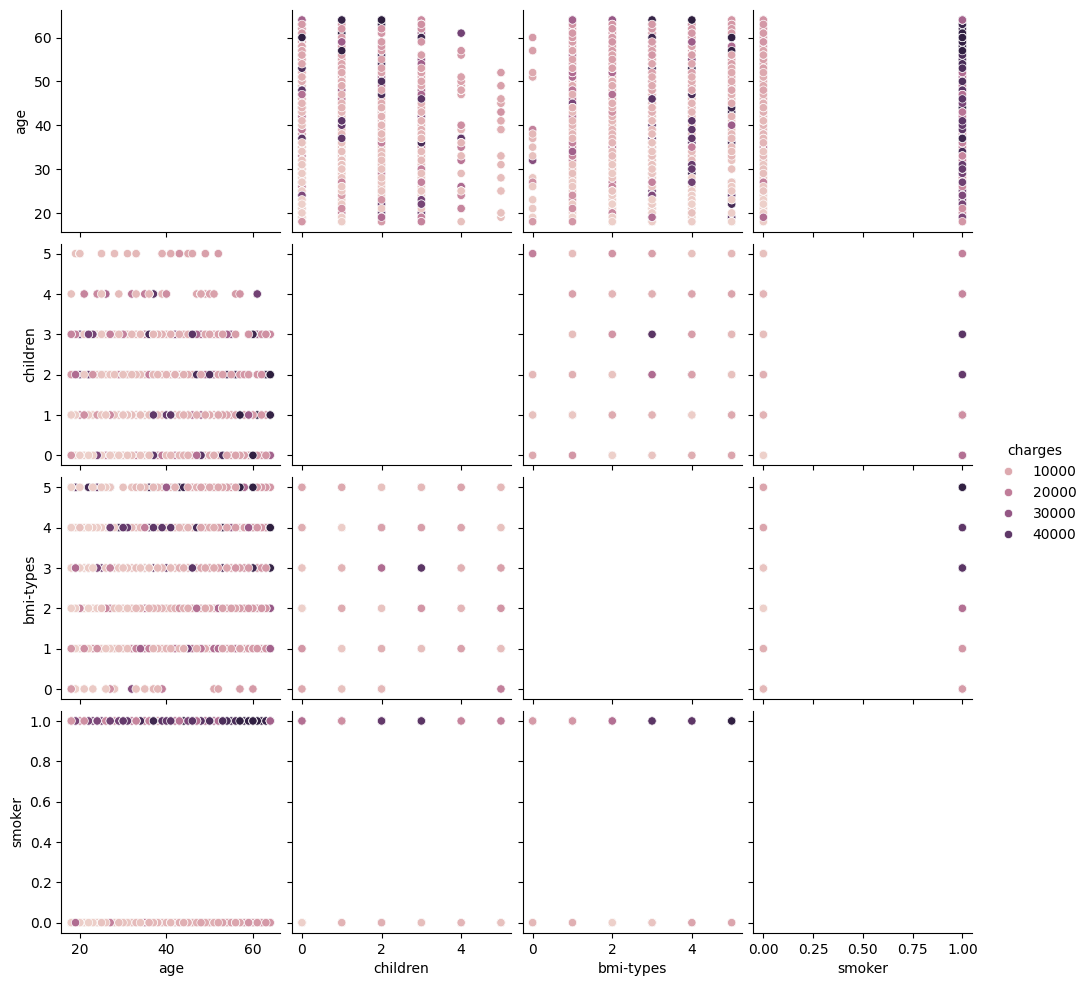

In [12]:
sb.pairplot(dados,vars=[COL_AGE, COL_CHILDREN, COL_BMI_TYPES, COL_SMOKER],hue=COL_CHARGES)


**3.2 - Correlações**

<Axes: >

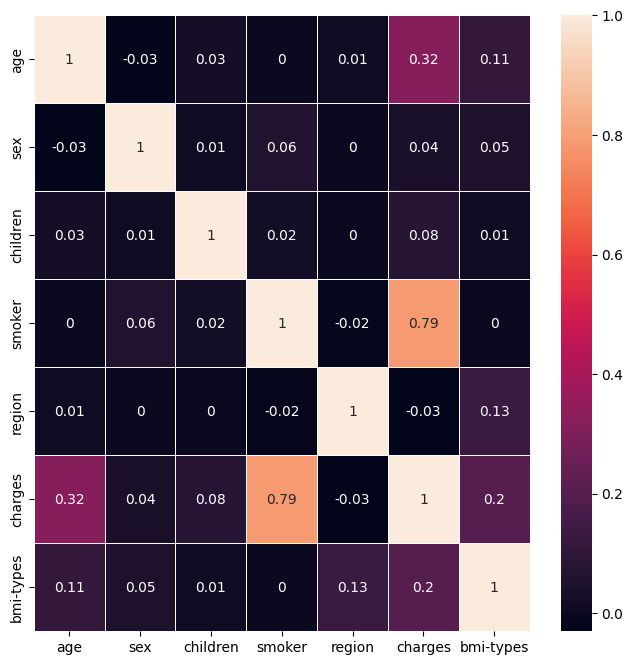

In [ ]:
correlation_matrix = dados.corr().round(2)
fig, ax = plt.subplots(figsize=(8,8))
sb.heatmap(data=correlation_matrix, annot=True, linewidths=.5, ax=ax)

**obs:** pode ser percebido que a correlação dos gastos com a pessoa fumante é alta de 0,79 e com bmi de 0,20 e de idade 0,32

In [ ]:
correlation_matrix = dados.corr()
max_corr = correlation_matrix.stack().sort_values(ascending=False).drop_duplicates()
max_corr = max_corr[max_corr < 1].head(10)

print("Maiores correlações:")
print(max_corr)

Maiores correlações:
smoker     charges      0.788153
age        charges      0.321103
bmi-types  charges      0.196639
           region       0.133129
           age          0.114130
children   charges      0.082119
smoker     sex          0.058125
sex        bmi-types    0.054603
           charges      0.041237
age        children     0.033065
dtype: float64


# 4 - Modelo baseado Regressão Linear

**Run model linear regression**

In [16]:
X, y = define_x_y()

shuffle_split = True

X_train, y_train, X_test, y_test = process_train_test(X, y, shuffle_split)

model, y_pred = linear_regression()

evaluate = model_evaluate(model, X_train, y_train, X_test, y_test, y_pred)

ratings = add_rating(evaluate, ratings)
ratings.head(20)

ShuffleSplit bmi-types: True
StandardScaler: False
removendo coluna bmi-types
Avaliando o desempenho do modelo: LinearRegression - r2-score: 0.6994180978176476


,model,shuffle_split_bmi,upsampling,standard_scaler,removed_outliers,mae,mse,rmse,mape,r2-score,k-fold std,k-fold mean
0,LinearRegression,False,False,False,False,4219.58,35696181.76,5974.63,43.20,0.8057,0.042037,0.743021
1,DecisionTreeRegressor,False,False,False,False,3225.79,43767559.59,6615.71,39.92,0.7618,0.048005,0.692147
2,RandomForestRegressor,False,False,False,False,2729.80,23512302.73,4848.95,33.21,0.8720,0.029680,0.821714
3,LinearRegression,True,False,False,False,4383.17,48738372.28,6981.29,32.07,0.7112,0.042037,0.743021
4,DecisionTreeRegressor,True,False,False,False,4526.64,79649610.50,8924.66,35.82,0.5280,0.048005,0.692147
5,RandomForestRegressor,True,False,False,False,4431.14,57342335.18,7572.47,36.82,0.6602,0.029680,0.821714
6,LinearRegression,False,False,False,True,4323.11,38015436.96,6165.67,41.41,0.7298,0.038866,0.748163
7,DecisionTreeRegressor,False,False,False,True,3090.34,43508695.37,6596.11,35.51,0.6908,0.061678,0.709565
8,RandomForestRegressor,False,False,False,True,2767.83,24622223.52,4962.08,33.74,0.8250,0.028388,0.821448
9,LinearRegression,True,False,False,True,3957.70,35100376.44,5924.56,32.16,0.7639,0.038866,0.748163


**Visualizando previsões**

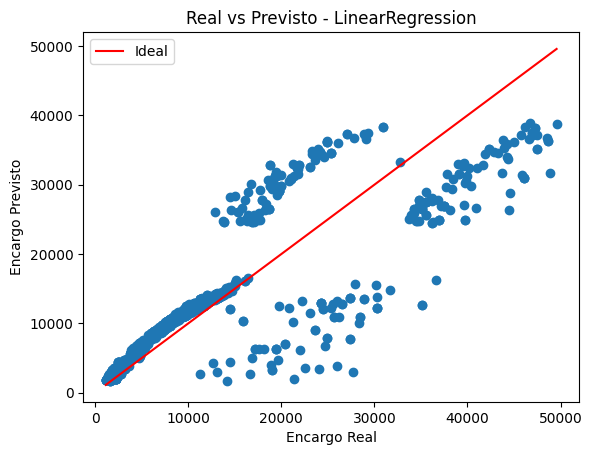

In [17]:
plt_real_previsto(y_test, y_pred, model)

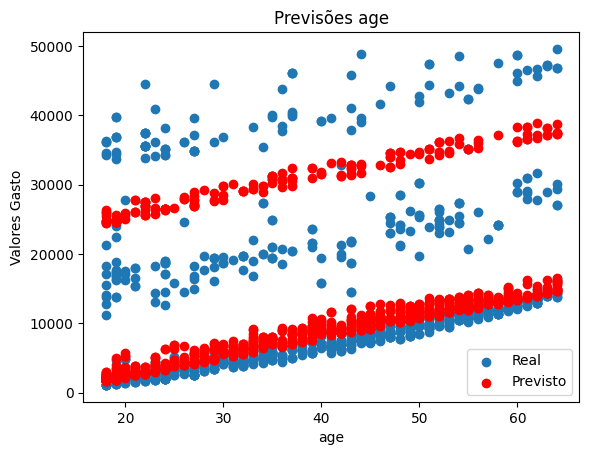

In [18]:

feature = COL_AGE

plt.scatter(X_test[feature], y_test, label='Real')
plt.scatter(X_test[feature], y_pred, label='Previsto', color='red')
plt.xlabel(feature)
plt.ylabel('Valores Gasto')
plt.title('Previsões age')
plt.legend()
plt.show()



# 5 - Modelo baseado em árvore (DecisionTreeRegressor) - - - - - - - - - - - -



**Run model decision_tree_regressor**

In [19]:
X, y = define_x_y()

shuffle_split = False

X_train, y_train, X_test, y_test = process_train_test(X, y, shuffle_split)

model, y_pred = decision_tree_regressor()

evaluate = model_evaluate(model, X_train, y_train, X_test, y_test, y_pred)

ratings = add_rating(evaluate, ratings)
ratings.head(20)

ShuffleSplit bmi-types: False
StandardScaler: False
Avaliando o desempenho do modelo: DecisionTreeRegressor - r2-score: 0.9774549886622301


,model,shuffle_split_bmi,upsampling,standard_scaler,removed_outliers,mae,mse,rmse,mape,r2-score,k-fold std,k-fold mean
0,LinearRegression,False,False,False,False,4219.58,35696181.76,5974.63,43.20,0.8057,0.042037,0.743021
1,DecisionTreeRegressor,False,False,False,False,3225.79,43767559.59,6615.71,39.92,0.7618,0.048005,0.692147
2,RandomForestRegressor,False,False,False,False,2729.80,23512302.73,4848.95,33.21,0.8720,0.029680,0.821714
3,LinearRegression,True,False,False,False,4383.17,48738372.28,6981.29,32.07,0.7112,0.042037,0.743021
4,DecisionTreeRegressor,True,False,False,False,4526.64,79649610.50,8924.66,35.82,0.5280,0.048005,0.692147
5,RandomForestRegressor,True,False,False,False,4431.14,57342335.18,7572.47,36.82,0.6602,0.029680,0.821714
6,LinearRegression,False,False,False,True,4323.11,38015436.96,6165.67,41.41,0.7298,0.038866,0.748163
7,DecisionTreeRegressor,False,False,False,True,3090.34,43508695.37,6596.11,35.51,0.6908,0.061678,0.709565
8,RandomForestRegressor,False,False,False,True,2767.83,24622223.52,4962.08,33.74,0.8250,0.028388,0.821448
9,LinearRegression,True,False,False,True,3957.70,35100376.44,5924.56,32.16,0.7639,0.038866,0.748163


**Visualizando as previsões**

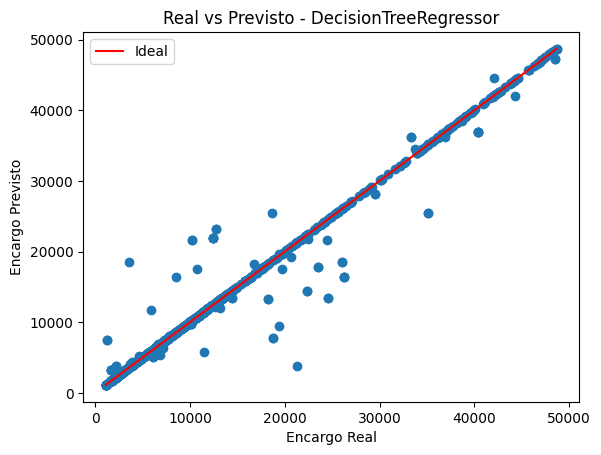

In [20]:
plt_real_previsto(y_test, y_pred, model)

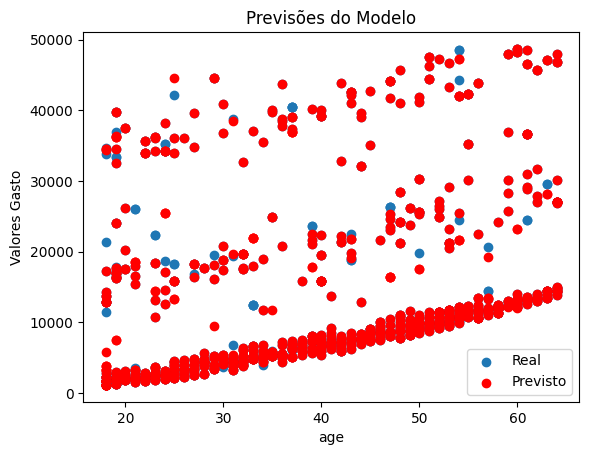

In [21]:
feature = COL_AGE

plt.scatter(X_test[feature], y_test, label='Real')
plt.scatter(X_test[feature], y_pred, label='Previsto', color='red')
plt.xlabel(feature)
plt.ylabel('Valores Gasto')
plt.title('Previsões do Modelo')
plt.legend()
plt.show()

# 6 - Modelo baseado em árvore (RandomForestRegressor) - - - - - - - - - - - - - -

**Run model random_tree_regressor**

In [23]:
X, y = define_x_y()

shuffle_split = True

X_train, y_train, X_test, y_test = process_train_test(X, y, shuffle_split)

model, y_pred = radom_forest_regressor()

evaluate = model_evaluate(model, X_train, y_train, X_test, y_test, y_pred)

ratings = add_rating(evaluate, ratings)
ratings.head(20)

ShuffleSplit bmi-types: True
StandardScaler: False
removendo coluna bmi-types
Avaliando o desempenho do modelo: RandomForestRegressor - r2-score: 0.9103506179130831


,model,shuffle_split_bmi,upsampling,standard_scaler,removed_outliers,mae,mse,rmse,mape,r2-score,k-fold std,k-fold mean
0,LinearRegression,False,False,False,False,4219.58,35696181.76,5974.63,43.20,0.8057,0.042037,0.743021
1,DecisionTreeRegressor,False,False,False,False,3225.79,43767559.59,6615.71,39.92,0.7618,0.048005,0.692147
2,RandomForestRegressor,False,False,False,False,2729.80,23512302.73,4848.95,33.21,0.8720,0.029680,0.821714
3,LinearRegression,True,False,False,False,4383.17,48738372.28,6981.29,32.07,0.7112,0.042037,0.743021
4,DecisionTreeRegressor,True,False,False,False,4526.64,79649610.50,8924.66,35.82,0.5280,0.048005,0.692147
5,RandomForestRegressor,True,False,False,False,4431.14,57342335.18,7572.47,36.82,0.6602,0.029680,0.821714
6,LinearRegression,False,False,False,True,4323.11,38015436.96,6165.67,41.41,0.7298,0.038866,0.748163
7,DecisionTreeRegressor,False,False,False,True,3090.34,43508695.37,6596.11,35.51,0.6908,0.061678,0.709565
8,RandomForestRegressor,False,False,False,True,2767.83,24622223.52,4962.08,33.74,0.8250,0.028388,0.821448
9,LinearRegression,True,False,False,True,3957.70,35100376.44,5924.56,32.16,0.7639,0.038866,0.748163


**Vizualizando as previsões**

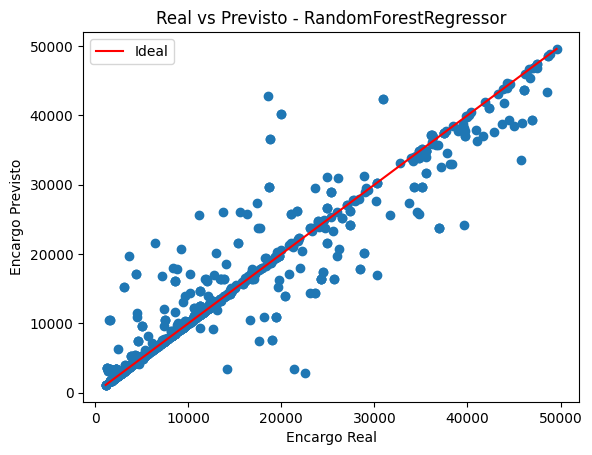

In [24]:
plt_real_previsto(y_test, y_pred, model)

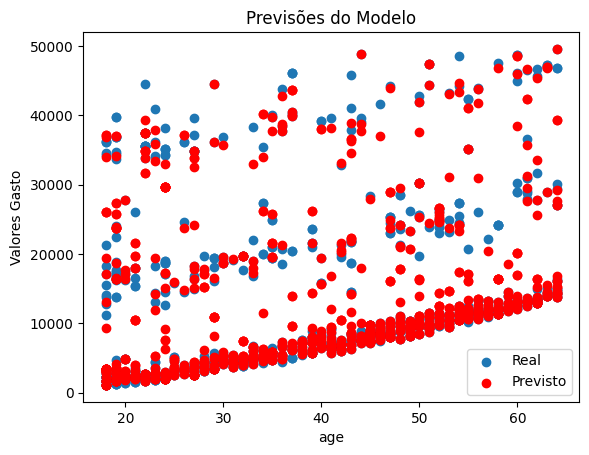

In [25]:
feature =  COL_AGE

plt.scatter(X_test[feature], y_test, label='Real')
plt.scatter(X_test[feature], y_pred, label='Previsto', color='red')
plt.xlabel(feature)
plt.ylabel('Valores Gasto')
plt.title('Previsões do Modelo')
plt.legend()
plt.show()

# 7 - Executando todos os modelos

**Inicializando e processando a base dados**

In [9]:
dados = pd.read_csv("medical_insurance.csv")

removed_duplicated = True
removed_outliers = True
upsampling = True

dados = process_database(dados, removed_duplicated, removed_outliers, upsampling)

#ratings = pd.DataFrame();

Número de registros duplicados: 1435
(2772, 7)
removendo dados duplicados...
(1337, 7)
removendo outliers...
(1330, 7)
run_upsampling
(5000, 7)
encoded_labels: ['sex', 'smoker', 'region']
categorizando a coluna bmi -> bmi-types


**Run modelos**

In [10]:
#ratings = pd.DataFrame();

X, y = define_x_y()

standard_scaler = False

shuffle_split = False
X_train, y_train, X_test, y_test = process_train_test(X, y, shuffle_split, standard_scaler)

ratings = model_run("linear_regression", ratings)
ratings = model_run("decision_tree_regressor", ratings)
ratings = model_run("radom_forest_regressor", ratings)

shuffle_split = True
X_train, y_train, X_test, y_test = process_train_test(X, y, shuffle_split, standard_scaler)

ratings = model_run("linear_regression", ratings)
ratings = model_run("decision_tree_regressor", ratings)
ratings = model_run("radom_forest_regressor", ratings)


print("\nResultado: Ordenado pelo melhor r2")
ratings.sort_values(by='r2-score', ascending=False)

ShuffleSplit bmi-types: False
StandardScaler: False
Avaliando o desempenho do modelo: LinearRegression - r2-score: 0.7539867878106653
Avaliando o desempenho do modelo: DecisionTreeRegressor - r2-score: 0.9774549886622301
Avaliando o desempenho do modelo: RandomForestRegressor - r2-score: 0.9709560577754451
ShuffleSplit bmi-types: True
StandardScaler: False
removendo coluna bmi-types
Avaliando o desempenho do modelo: LinearRegression - r2-score: 0.6994180978176476
Avaliando o desempenho do modelo: DecisionTreeRegressor - r2-score: 0.90791085511829
Avaliando o desempenho do modelo: RandomForestRegressor - r2-score: 0.9103506179130831

Resultado: Ordenado pelo melhor r2


,model,shuffle_split_bmi,upsampling,standard_scaler,removed_outliers,mae,mse,rmse,mape,r2-score,k-fold std,k-fold mean
13,DecisionTreeRegressor,False,True,False,True,378.63,3225446.49,1795.95,4.04,0.9775,0.011799,0.973855
14,RandomForestRegressor,False,True,False,True,654.84,4155228.85,2038.44,7.63,0.9710,0.008671,0.973253
17,RandomForestRegressor,True,True,False,True,1309.50,11283051.77,3359.03,13.53,0.9104,0.008671,0.973253
16,DecisionTreeRegressor,True,True,False,True,1040.70,11590114.35,3404.43,11.27,0.9079,0.011799,0.973855
2,RandomForestRegressor,False,False,False,False,2729.80,23512302.73,4848.95,33.21,0.8720,0.029680,0.821714
8,RandomForestRegressor,False,False,False,True,2767.83,24622223.52,4962.08,33.74,0.8250,0.028388,0.821448
0,LinearRegression,False,False,False,False,4219.58,35696181.76,5974.63,43.20,0.8057,0.042037,0.743021
9,LinearRegression,True,False,False,True,3957.70,35100376.44,5924.56,32.16,0.7639,0.038866,0.748163
1,DecisionTreeRegressor,False,False,False,False,3225.79,43767559.59,6615.71,39.92,0.7618,0.048005,0.692147
12,LinearRegression,False,True,False,True,4146.38,35196365.19,5932.65,39.81,0.7540,0.022724,0.739185


In [ ]:
print("Resultado: Ordenado pelo melhor r2")
ratings.sort_values(by='r2-score', ascending=False)

**Desempenho do modelo de regressão:**

**- Mean Absolute Error (mae):**

mede a média das diferenças absolutas entre as previsões do modelo e os valores reais. Em termos simples, o MAE nos diz quão distantes, em média, as previsões estão dos valores reais. Quanto menor o valor do MAE, mais precisas são as previsões do modelo. É uma medida direta da qualidade das previsões, sem levar em conta a direção dos erros.

**- Mean Squared Error (mse):**

Em vez de calcular a média das diferenças absolutas entre previsões e valores reais, o MSE calcula a média dos quadrados dessas diferenças. Isso significa que o MSE penaliza erros grandes de forma mais significativa do que erros menores. Assim como o MAE, quanto menor o valor do MSE, melhor o desempenho do modelo. No entanto, como os erros são elevados ao quadrado, o MSE tende a ser mais sensível a valores extremos do que o MAE.

**- Erro Quadrático Médio da Raiz (rmse):**

 é uma versão do MSE que leva em conta a raiz quadrada dos erros quadráticos médios. Em essência, o RMSE é uma medida da dispersão dos erros entre as previsões e os valores reais. Como o MSE, o RMSE também penaliza erros grandes, mas devido à raiz quadrada, sua unidade é a mesma dos dados originais, o que facilita a interpretação. Assim como o MSE, quanto menor o valor do RMSE, melhor o desempenho do modelo de regressão.

**- R² Score (r2):**

é uma métrica que nos ajuda a entender o quanto as variações nas variáveis independentes explicam as variações na variável que estamos tentando prever (variável dependente) em um modelo de regressão. Quanto mais próximo de 1, melhor o modelo está em explicar a variabilidade dos dados. No entanto, é importante observar que o R² Score não indica a qualidade absoluta do modelo, mas sim a adequação do modelo em relação aos dados utilizados.

**- Mean Absolute Percentage Error (mape):**

 é uma métrica usada para avaliar a precisão de previsões em relação aos valores reais, expressando o erro médio como uma porcentagem do valor real. Ele calcula a média das diferenças percentuais absolutas entre as previsões e os valores reais.

In [ ]:
dados.head()

,age,sex,children,smoker,region,charges,bmi-types
0,55,1,0,0,3,10214.63600,2
1,37,0,2,1,3,46113.51100,5
2,58,1,0,0,0,11931.12525,2
3,39,0,5,0,2,8582.30230,1
4,18,0,4,0,0,4561.18850,3
